## Problem Set 1: Question 1

This first chunk shows the required libraries. Everything should be included in e.g. Conda Python. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size

import numpy as np

## Implement the model


In [2]:
class ngm():

    def __init__(self, σ=1, β=0.984, δ=0.025, α=1/3):
        'Parameters:'
        self.σ, self.β, self.δ, self.α = σ, β, δ, α
        
        'Endogenous outcomes and endogenous grid:'
        self.steadystate = self.ss()
        self.k0 = 0.75*self.ss()
        self.grid = self.create_grid(self.steadystate)
        self.v_initial = self.v_initial()

    def u(self, c):
        'Utility function'
        σ = self.σ

        return (c ** (1 - σ) - 1) / (1 - σ) if σ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        σ = self.σ

        return c ** (-σ)

    def f(self, k):
        'Production function'
        α = self.α

        return k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α = self.α

        return α * k ** (α - 1)
    
    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α = self.α 

        return (k / α) ** (1 / (α - 1))

    def ss(self):
        'Define the steady-state equation s.t. RHS=0'
        β, δ = self.β, self.δ
        f_prime_inv = self.f_prime_inv
        
        return f_prime_inv(1/β - (1-δ))
    
    def create_grid(self, reference):
        'Create a grid as prescribed in the assignment'
        grid = np.linspace(0.5 * reference, 1.5 * reference, 1000)
        return grid
    
    def v_initial(self):
        'Create initialization for value function'
        grid = self.grid
        v_initial = np.zeros_like(grid)
        return v_initial      
    
    def state_action_value(self, k_new, k, v_array):
        v = lambda x: interp(self.grid, v_array, x)
        
        u, f = self.u, self.f
        β, δ = self.β, self.δ
        return u(f(k) + (1-δ)*k - k_new) + β*v(k_new)   #k_new is the thing we solve for
                                                        # This is the right hand side of the bellman

## Implement the algorithm

As in the assignment:

In [3]:
def u_mat(ngm, v):
    grid = ngm.grid
    u, f = ngm.u, ngm.f
    β, δ = ngm.β, ngm.δ
    
    u_out = np.zeros((len(ngm.grid), len(ngm.grid)))
    
    for i in range(len(grid)):
        
        for j in range(len(grid)):
            
            if (grid[j] > (1-δ)*grid[i] and grid[j] < f(grid[i]) + (1-δ)*grid[i]):
                
                u_out[i,j] = u(f(grid[i]) + (1-δ)*grid[i] - grid[j]) + β*v[j]
            
            else:
                u_out[i,j] = -np.Inf
                   
    return u_out
            

In [4]:
def value_function_iteration(ngm,
                             tol=1e-4,
                             max_iter=1000,
                             verbose=True,
                             print_skip=100):
    'Compute the value function through the fixed point of a contraction mapping'
    # Set up loop
    v = ngm.v_initial # Initial guess
    initial_u = u_mat(ngm, v)
    
    i = 0
    error = tol + 1
    
    while i < max_iter and error > tol:
        
        new_u = initial_u + ngm.β*v
        v_new, k_new = np.max(new_u, axis=1), np.argmax(new_u, axis=1)
        
        
        error = np.max(np.abs(v - v_new))
        i += 1
        
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
            
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new, k_new

In [5]:
v_conv, k_conv_index = value_function_iteration(ngm())

vconv_five, k_conv_index_five = value_function_iteration(ngm(σ=5))

Error at iteration 100 is 0.15208361821300542.
Error at iteration 200 is 0.03021402670641038.
Error at iteration 300 is 0.0060216908022496796.
Error at iteration 400 is 0.0012001300082005173.
Error at iteration 500 is 0.0002391873120046739.

Converged in 555 iterations.
Error at iteration 100 is 0.048477169271352594.
Error at iteration 200 is 0.009619938872637235.
Error at iteration 300 is 0.0019154393736240394.
Error at iteration 400 is 0.0003817493037523434.

Converged in 484 iterations.


In [13]:
def plot_policies(ngm, ngm2, k_conv_index, k_conv_index2, T):
    'Plot the policy a partir de k0'
    # First ngm
    grid = ngm.grid
    k = []
    k0 = grid.flat[np.abs(ngm.grid - ngm.k0).argmin()]
    
    k.append(k0)
    
    # Second ngm
    grid2 = ngm2.grid
    k2 = []
    k02 = grid2.flat[np.abs(ngm2.grid - ngm2.k0).argmin()]
    
    k2.append(k02)
    
    
    for i in range(T):
        index = k_conv_index[grid == k[i]][0]
        k.append(grid[index])
        
        index2 = k_conv_index2[grid2 == k2[i]][0]
        k2.append(grid2[index2])
        
    fig, ax = plt.subplots()
    ax.plot(range(T+1), k, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label = 'Policy Path Starting from k0 (σ=1)')
    
    ax.plot(range(T+1), k2, color=plt.cm.jet(1/5),
        lw=2, alpha=0.6, label = 'Policy Path Starting from k0 (σ=5)')
    
    ax.legend()
    ax.set_ylabel('Optimal Capital Chosen', fontsize=12)
    ax.set_xlabel('Time $t$', fontsize=12)
    ax.set_title('Optimal Policy Starting from $K_0$')
    
    plt.savefig("question1_fig.pdf")
    print('The steady state of this model (σ=1) is:', ngm.steadystate)
    print('The steady state of this model (σ=5) is:', ngm2.steadystate)
    
    plt.show()

The steady state of this model (σ=1) is: 22.962634609403963
The steady state of this model (σ=5) is: 22.962634609403963


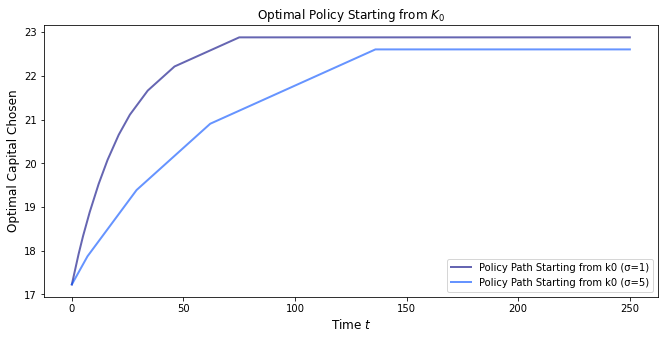

In [14]:
plot_policies(ngm(), ngm(σ=5), k_conv_index, k_conv_index_five, 250)